##### In this notebook is presented a pipeline for the application of the Canny algorithm to several images and the respective calculation of Frontal Probabilities fot the period that we are analysing. This pipeline is designed to use only MUR or reanalysis data, but it will be quite simple to apply this pipeline to other types of data

In the Calculation of Frontal Probabilities using Canny, the algorithm is going to return a matrix in which each pixel will have a certain probability (from 0 to 100) of being considered a front, accordingly to a certain period of time. Ex: if for a period of 30 days, Canny considers that that pixel is a front in all of the 30 days, then, that pixel will have a frontal probability of 100%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import cv2
import xarray as xr
import os
from pathlib import Path
from scipy.ndimage import gaussian_filter
plt.rcParams["figure.figsize"] = 12, 10
%matplotlib inline
import cmocean
import matplotlib
from matplotlib.colors import ListedColormap

## Import Data

In [2]:
def get_data(data):
    
    """
    function to get our netCDF file that is stored in the data directory, convert it to a dataframe and return it.
    the data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #if we are importing MUR data, we need to rename the columns and convert the SST values to Celsius
    if data.startswith('mur'):
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   #convert to Celsius
        
    
    return df

In [3]:
df_reanalysis = get_data('IBI2014-2019.nc')      #import reanalysis data as a dataframe

In [3]:
df_mur_july = get_data('murJuly2019.nc')

In [4]:
df_mur_aug = get_data('murAugust2019.nc')

In [5]:
df_mur_sept = get_data('murSept2019.nc')

In [6]:
def get_period(df):
    
    """
    Function that receives a dataframe that has SST data for different days 
    and returns a dictionaire of dataframes (one for each different day) (dict_df) and 
    an array with the different dates its possible to find in our dataframe (specificday)
    """
    
    specificday = [pd.Timestamp(dd).strftime("%Y-%m-%d %H:%M:%S") for dd in df['time'].unique()]
    specificday = np.array(specificday, dtype=np.object)
  
    #create a dictionary to store the data frames for each day
    dict_df = {elem : pd.DataFrame for elem in specificday}

    for key in dict_df.keys():
        dict_df[key] = df[:][df['time'] == key]
        
    return dict_df, specificday

#after this function we only have to define the period we want to analyse

In [8]:
dict_df_mur_set, specificday_mur_set = get_period(df_mur_sept)
#dict_df_mur_set -> dictionaire of dataframes for each day of September of the MUR data
#specificday_mur_set -> array with all the days of september 

In [6]:
dict_df_mur_aug, specificday_mur_aug = get_period(df_mur_aug)

In [9]:
dict_df_mur_july, specificday_mur_july = get_period(df_mur_july)

In [29]:
dict_df_r, specificday_r = get_period(df_reanalysis)

##### Define the period we want to analyse

Here we can choose the period of time (ex: summer of 2019) that we want to analyse

In [9]:
# period we want to analyse
ond2014_2019 = specificday_r[(specificday_r>='2014-10-01 12:00:00') & (specificday_r <= '2014-12-31 12:00:00') + (specificday_r>='2015-10-01 12:00:00') & (specificday_r <= '2015-12-31 12:00:00')+(specificday_r>='2016-10-01 12:00:00') & (specificday_r <= '2016-12-31 12:00:00')+(specificday_r>='2017-10-01 12:00:00') & (specificday_r <= '2017-12-31 12:00:00')+(specificday_r>='2018-10-01 12:00:00') & (specificday_r <= '2018-12-31 12:00:00')+(specificday_r>='2019-10-01 12:00:00') & (specificday_r <= '2019-12-31 12:00:00')]
ond2014_2019

array(['2014-10-01 12:00:00', '2014-10-02 12:00:00',
       '2014-10-03 12:00:00', '2014-10-04 12:00:00',
       '2014-10-05 12:00:00', '2014-10-06 12:00:00',
       '2014-10-07 12:00:00', '2014-10-08 12:00:00',
       '2014-10-09 12:00:00', '2014-10-10 12:00:00',
       '2014-10-11 12:00:00', '2014-10-12 12:00:00',
       '2014-10-13 12:00:00', '2014-10-14 12:00:00',
       '2014-10-15 12:00:00', '2014-10-16 12:00:00',
       '2014-10-17 12:00:00', '2014-10-18 12:00:00',
       '2014-10-19 12:00:00', '2014-10-20 12:00:00',
       '2014-10-21 12:00:00', '2014-10-22 12:00:00',
       '2014-10-23 12:00:00', '2014-10-24 12:00:00',
       '2014-10-25 12:00:00', '2014-10-26 12:00:00',
       '2014-10-27 12:00:00', '2014-10-28 12:00:00',
       '2014-10-29 12:00:00', '2014-10-30 12:00:00',
       '2014-10-31 12:00:00', '2014-11-01 12:00:00',
       '2014-11-02 12:00:00', '2014-11-03 12:00:00',
       '2014-11-04 12:00:00', '2014-11-05 12:00:00',
       '2014-11-06 12:00:00', '2014-11-07 12:0

In [9]:
set2019_mur = specificday_mur_set[(specificday_mur_set >='2019-09-01 09:00:00') & (specificday_mur_set<='2019-09-30 09:00:00')]

In [11]:
set2019_r = specificday_r[(specificday_r >='2019-09-01 12:00:00') & (specificday_r<='2019-09-30 12:00:00')]

In [30]:
summer2019_r = specificday_r[(specificday_r >='2019-07-01 12:00:00') & (specificday_r<='2019-09-30 12:00:00')]

## Canny Algorithm

In [31]:
def canny_front_calc(dict_df, Tmin, Tmax, sigma=0, apertureSize=3):  
    
    """
    Function that receives a dataframe with SST data relative to a certain day and returns the front matrix 
    obtained due to the aplication of the Canny algorithm.
    For each image a Gaussian filter (with a certain sigma value) might be applied (depending on the data)
    Tmin and Tmax are the limits of the threshold and apertureSize is the size of the Sobel operator (default=3X3)
    """
    
    #Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
    Temp = dict_df.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
    
    #Convert the temperature values to the uint8 format with values between 0-255
    Temp_day = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')

    Temp_day = np.flipud(Temp_day)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
    #if its MUR data we have to apply gaussian filter with certain sigma value (~5)
    Temp_day = gaussian_filter(Temp_day, sigma=sigma)
    
    #apply the canny algorithm 
    canny = cv2.Canny(Temp_day, Tmin, Tmax, L2gradient=False, apertureSize=apertureSize)
    
    
    return canny  #return the matrix (if a pixel was considered a front than its value is 255; otherwise is 0)

In [32]:
def frontal_prob(period, dict_df, Tmin, Tmax, MUR=False, sigma=0, apertureSize=3):
    """
    This function receives several front matrices and for that period calculates the frontal_probability. 
    Then it creates a masked_array so that the continental zone is well defined.
    This masked_array is applied to the frontal probabilities matrix, which is returned
    """
    
    #the fp is the frontal probability array that initially is define as a matrix of zeros with a certain shape (accordingly to the data)
    if MUR==False:
        fp = np.zeros((121,169))    #if it's not MUR (than it reanalysis/model data) which shape is (121, 169)
    elif MUR==True: 
        fp = np.zeros((1001,1401))   #if its MUR data, fp shape must be (1001, 1401)
        
    for day in period:             #for each day in period we sum fp with the matrix resulted from canny
        fp = fp + canny_front_calc(dict_df[day], Tmin=Tmin, Tmax=Tmax, sigma=sigma, apertureSize=apertureSize)
    
    fp = fp/(len(period)*255)*100    # to get the fp in percentage 
    
    
    #Create a mask for our continental zone
    sst = dict_df[period[0]].pivot_table(index='longitude', columns='latitude', values='thetao').T.values  
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    return fp 

In [40]:
def frontal_prob_visualization(period, dict_df, Tmin, Tmax, MUR, sigma, apertureSize, vmin=None, vmax=None):
    
    """
    Function to visualize the map of frontal probability and an histogram with the frontal probabilities
    vmin and vmax define the data range that the colormap covers -> it helps for visualization purposes.
    """
    
    #first we apply the frontal_prob function to a certain period of data
    fp = frontal_prob(period=period, dict_df=dict_df, Tmin=Tmin, Tmax=Tmax, MUR=MUR, sigma=sigma, apertureSize=apertureSize)
    
    #for the definition of the extent in the imshow() -> so we see the values of long and latitude in our plot
    lat = np.array(dict_df[period[0]]['latitude'].unique())
    lon = np.array(dict_df[period[0]]['longitude'].unique())
    
    #so that all pixels with value 0 became white pixels
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')

    
    plt.rcParams["figure.figsize"] = (15, 25)
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    img = ax1.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.colorbar(img, orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)
    plt.title("Canny - Frontal Probabilities Summer 2019 (Reanalysis Data)", fontsize=25)

    ax2 = fig.add_subplot(2,1,2)
    ax2.hist(fp.flatten(), bins=100);
    plt.xlabel('Frontal Probability',fontsize=10)
    


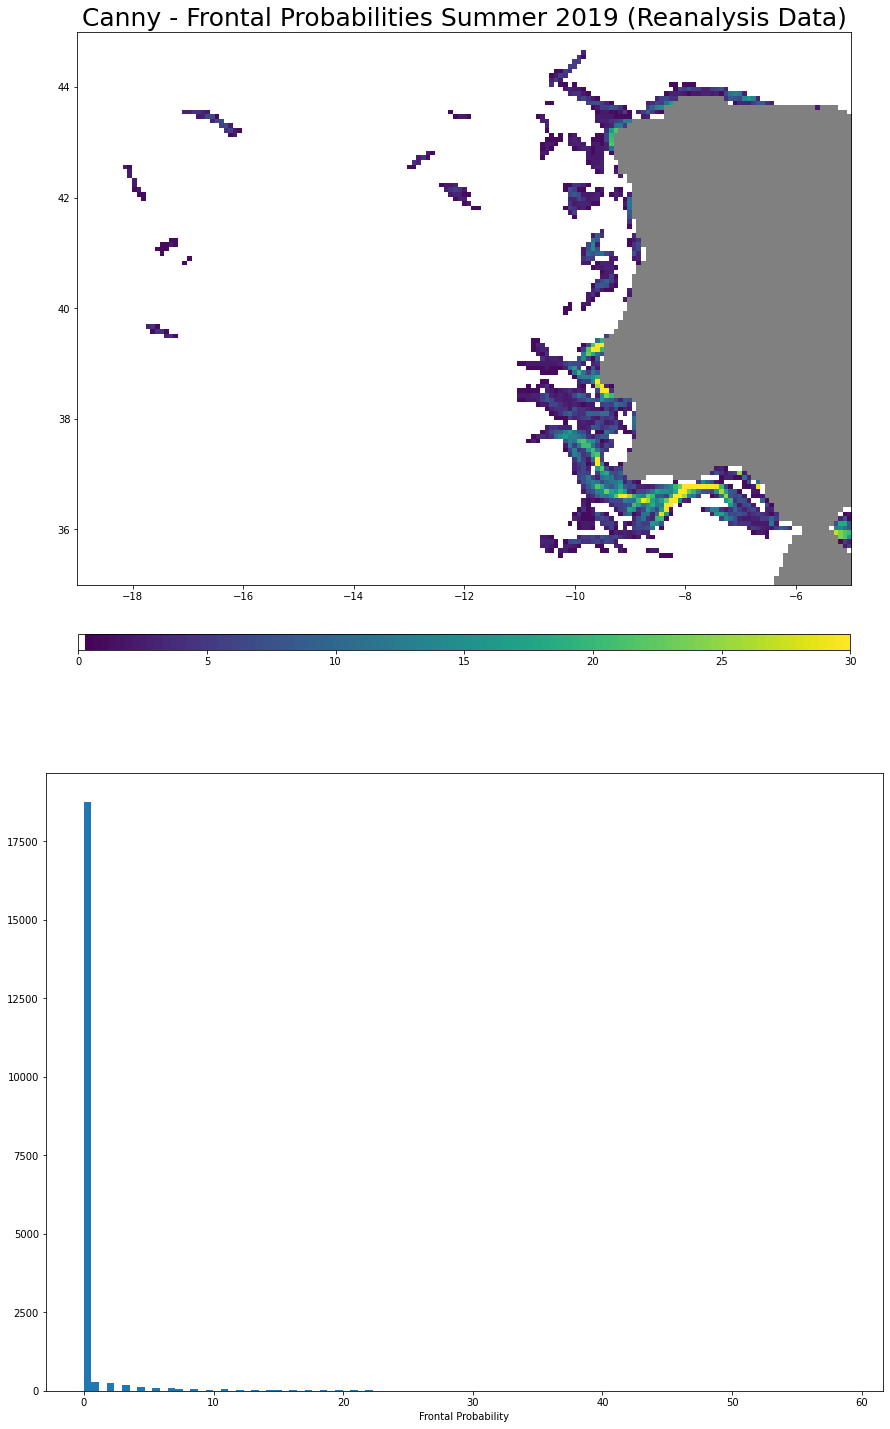

In [41]:
frontal_prob_visualization(period = summer2019_r, dict_df=dict_df_r, Tmin=200, Tmax=220, MUR=False, sigma=0, apertureSize=3, vmax=30)

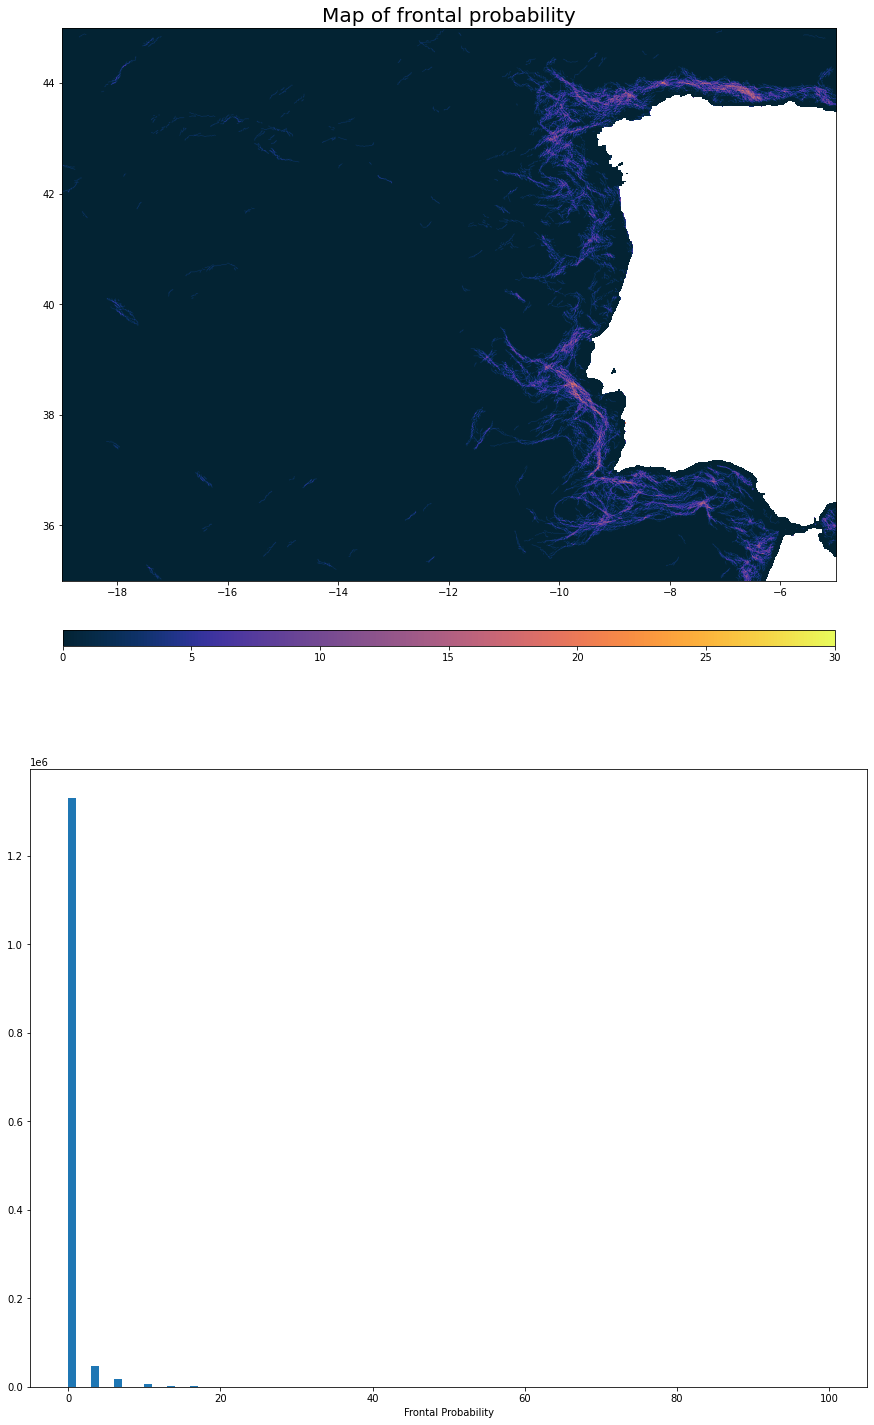

In [15]:
frontal_prob_visualization(period = set2019_mur, dict_df=dict_df_mur_set, Tmin=200, Tmax=300, MUR=True, sigma=5, apertureSize=5, vmax=30)

### Visualization Purposes:

Depending on the characteristics of the data we are using, namely the resolution, it will be necessary to vary some parameters of the canny_visualization function in order to obtain the best possible visualization. For example in the case of MUR data whose SST matrix has a shape (1001, 1401), for visualization purposes it is necessary to set a sigma value to reduce image noise; the aperturesize should be a 5X5 array instead of 3X3 (used in lower resolution images) and the thresholds limits should be a little higher (compared to lower resolution images). It also might be useful to vary parameters such as vmin e vmax that define the data range that the colormap covers.

#### To aggregate the various netCDFs from the MUR data and apply the algorithm

Due to their size the netCDF files for the MUR data were imported separately (1 month at a time). Thus the code below aims to merge several netCDFs in order to apply the Canny Algorithm to a larger time spectrum.

In [10]:
dict_df_mur_sept, specificday_mur_sept = get_period(df_mur_sept)

In [11]:
dict_df_mur_aug, specificday_mur_aug = get_period(df_mur_aug)

In [12]:
dict_df_mur_july, specificday_mur_july = get_period(df_mur_july)

In [13]:
def Merge(dict1, dict2):
    """
    Function to merge 2 dictionaires
    """
    
    res = {**dict1, **dict2}
    return res

In [14]:
dict_df_mur_augSet = Merge(dict_df_mur_aug, dict_df_mur_sept)

In [15]:
dict_df_mur_summer = Merge(dict_df_mur_july, dict_df_mur_augSet)

In [16]:
dict_df_mur_summer

{'2019-07-01 09:00:00':           latitude  longitude                time     thetao
 0             35.0 -19.000000 2019-07-01 09:00:00  21.459015
 31            35.0 -18.990000 2019-07-01 09:00:00  21.488007
 62            35.0 -18.980000 2019-07-01 09:00:00  21.506012
 93            35.0 -18.969999 2019-07-01 09:00:00  21.509003
 124           35.0 -18.959999 2019-07-01 09:00:00  21.502991
 ...            ...        ...                 ...        ...
 43474276      45.0  -5.040000 2019-07-01 09:00:00  17.605988
 43474307      45.0  -5.030000 2019-07-01 09:00:00  17.605988
 43474338      45.0  -5.020000 2019-07-01 09:00:00  17.602997
 43474369      45.0  -5.010000 2019-07-01 09:00:00  17.596985
 43474400      45.0  -5.000000 2019-07-01 09:00:00  17.588989
 
 [1402401 rows x 4 columns],
 '2019-07-02 09:00:00':           latitude  longitude                time     thetao
 1             35.0 -19.000000 2019-07-02 09:00:00  21.085999
 32            35.0 -18.990000 2019-07-02 09:00:00  21.

In [17]:
specificday_mur_summer = np.concatenate([specificday_mur_july, specificday_mur_aug, specificday_mur_sept])

In [19]:
specificday_mur_summer

array(['2019-07-01 09:00:00', '2019-07-02 09:00:00',
       '2019-07-03 09:00:00', '2019-07-04 09:00:00',
       '2019-07-05 09:00:00', '2019-07-06 09:00:00',
       '2019-07-07 09:00:00', '2019-07-08 09:00:00',
       '2019-07-09 09:00:00', '2019-07-10 09:00:00',
       '2019-07-11 09:00:00', '2019-07-12 09:00:00',
       '2019-07-13 09:00:00', '2019-07-14 09:00:00',
       '2019-07-15 09:00:00', '2019-07-16 09:00:00',
       '2019-07-17 09:00:00', '2019-07-18 09:00:00',
       '2019-07-19 09:00:00', '2019-07-20 09:00:00',
       '2019-07-21 09:00:00', '2019-07-22 09:00:00',
       '2019-07-23 09:00:00', '2019-07-24 09:00:00',
       '2019-07-25 09:00:00', '2019-07-26 09:00:00',
       '2019-07-27 09:00:00', '2019-07-28 09:00:00',
       '2019-07-29 09:00:00', '2019-07-30 09:00:00',
       '2019-07-31 09:00:00', '2019-08-01 09:00:00',
       '2019-08-02 09:00:00', '2019-08-03 09:00:00',
       '2019-08-04 09:00:00', '2019-08-05 09:00:00',
       '2019-08-06 09:00:00', '2019-08-07 09:0

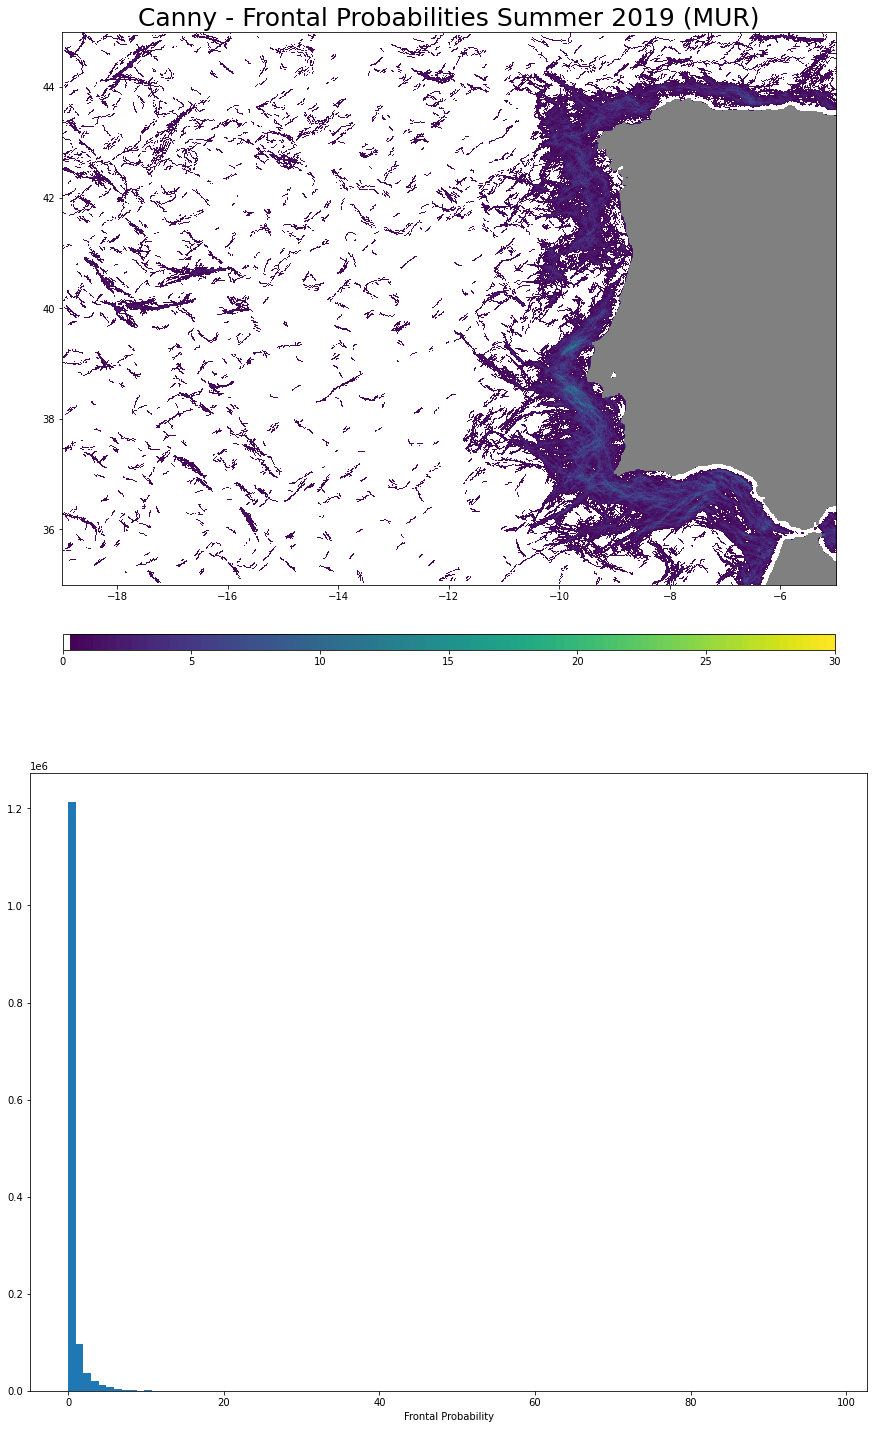

In [39]:
frontal_prob_visualization(period = specificday_mur_summer, dict_df=dict_df_mur_summer, Tmin=250, Tmax=300, MUR=True, sigma=5, apertureSize=5, vmax=30)